# Predictive Modeling

### Objective
Having explored the data and uncovered key relationships in the EDA phase, our primary goal is now to build and evaluate predictive models. We aim to accurately classify whether an individual will receive the H1N1 and seasonal flu vaccines based on their demographic, behavioral, and opinion-based features.

### Key Goals for This Phase:

1.  **Develop Two Separate Models**: We will create two distinct classification models:
    * A model to predict the likelihood of receiving the **H1N1 vaccine**.
    * A model to predict the likelihood of receiving the **seasonal flu vaccine**.

2.  **Address Class Imbalance**: The EDA revealed potential class imbalances in the target variables. We will implement strategies such as SMOTE (Synthetic Minority Over-sampling Technique) to ensure our models are not biased towards the majority class and can accurately predict for all individuals.

3.  **Feature Selection & Engineering**: We will use the insights from the EDA to select the most relevant features. We will also prepare the data for modeling through one-hot encoding for categorical variables and scaling for numerical features to ensure optimal model performance.

4.  **Model Training & Evaluation**: We will train several classification algorithms (such as Logistic Regression, Decision Trees, Random Forest, and XGBoost) and compare their performance using key metrics:
    * **Accuracy**: To measure overall correctness.
    * **Precision & Recall**: To understand the trade-offs between false positives and false negatives.
    * **ROC AUC Score**: To evaluate the model's ability to distinguish between classes.

5.  **Identify Key Predictive Factors**: A crucial outcome will be to use the final models to identify the most significant features that influence a person's vaccination decision. This will validate the hypotheses formed during the EDA and provide actionable insights for public health initiatives.

In [460]:
# import the libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings("ignore")
import re


#import sklearn libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE, SMOTEN
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
# from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline 

In [51]:
# load clean and encoded data from dataclean
df = pd.read_csv("cleantrain_labels.csv")

## Data Preprocessing

## Logistic Regression

### H1N1 VACCINE

In [120]:
# seperate features from predictor
x1 = df.drop(["respondent_id","seasonal_vaccine","h1n1_vaccine"], axis=1)
y1 = df.h1n1_vaccine

In [475]:
#seperate train and test set
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=.2, random_state=42, stratify=y)

#check shape
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((21365, 36), (5342, 36), (21365,), (5342,))

In [477]:
#Base model(logistic regresion)
lr1 = LogisticRegression()
lr1.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [126]:
print(f"The model score on training dataset is {lr1.score(x_train, y_train)*100:.2f}%")

The model score on training dataset is 83.59%


In [128]:
#check prediction and accuracy

y_pred = lr1.predict(x_test)

#accuracy
accuracy_score(y_test, y_pred)*100

83.71396480718832

In [130]:
conf = confusion_matrix(y_test, y_pred)
conf

array([[3989,  218],
       [ 652,  483]], dtype=int64)

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4207
           1       0.69      0.43      0.53      1135

    accuracy                           0.84      5342
   macro avg       0.77      0.69      0.71      5342
weighted avg       0.82      0.84      0.82      5342



The roc_score is : 0.8227652883959921


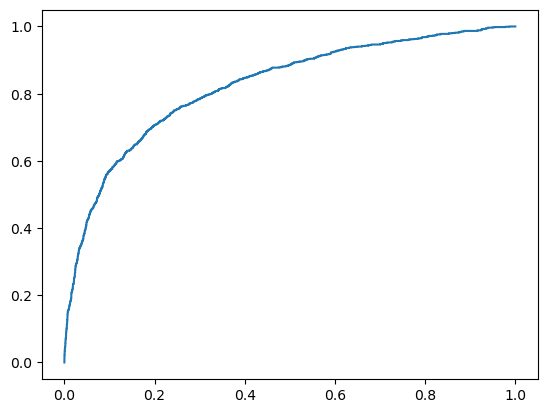

In [485]:
#create AUC score
y_pred_proba = lr1.predict_proba(x_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

print(f"The roc_score is : {roc_auc_score(y_test, y_pred_proba)}")
#plot
plt.plot(fpr, tpr);

**Observation and Summary**

The logistic regression model has a decent accuracy of **83.7%**, but this number is misleading. The model is very good at predicting the majority class **(class 0)** but performs poorly when identifying the minority class **(class 1)**, primarily due to a significant class imbalance the data.

Excellent Scores on the class(0) with good precision, recall and F1-score show that the model can accurately predict when someone doesnt take the H1N1 Vaccine shot but poor scores on the class(1) with bad precision, recall and F1-score means the model cannot predict when someone takes the shot

**The core issue is class imbalance.** The support column shows that there are  more samples for class 0 **(4,207)** than for class 1 **(1,135)**. Because of this, the model has become biased. It has learned that it can achieve high accuracy by mostly predicting the majority class (class 0). To improve the model, the focus should be on **improving the recall for class 1.**

#### With Feature scaling

In [135]:
# do feature scaling
ss = StandardScaler()
x_train_s =ss.fit_transform(x_train)
x_test_s =ss.transform(x_test)

In [137]:
#Base model(logistic regresion)

lr2 = LogisticRegression()
lr2.fit(x_train_s, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [139]:
print(f"The model score on training dataset is {lr2.score(x_train_s, y_train)*100:.2f}%")

The model score on training dataset is 83.59%


In [147]:
#check prediction and accuracy

y_pred_s = lr2.predict(x_test_s)

#accuracy
accuracy_score(y_test, y_pred_s)*100

83.71396480718832

In [149]:
lr2.score(x_test_s,y_test)

0.8371396480718832

In [151]:
conf = confusion_matrix(y_test, y_pred_s)
conf

array([[3989,  218],
       [ 652,  483]], dtype=int64)

#### Dealing with overfitting using ridge/lasso

#### Feature selection

In [161]:
# select best features
rfe = RFECV(estimator=lr2, min_features_to_select=10, step=1, cv=3, scoring="neg_mean_squared_error")
rfe = rfe.fit(x1,y1)
rfe

,estimator,LogisticRegression()
,step,1
,min_features_to_select,10
,cv,3
,scoring,'neg_mean_squared_error'
,verbose,0
,n_jobs,None
,importance_getter,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001


In [163]:
rfe.support_

array([ True,  True,  True, False,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True, False,  True, False,  True, False])

In [165]:
rfe.feature_names_in_

array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behavioral_outside_home', 'behavioral_touch_face',
       'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education',
       'income_poverty', 'census_msa', 'household_adults',
       'household_children', 'race_Hispanic', 'race_Other or Multiple',
       'race_White', 'sex_Male', 'rent_or_own_Rent',
       'employment_status_Not in Labor Force',
       'employment_status_Unemployed', 'marital_status_Not Married',
       'precautionary_score'], dtype=object)

In [167]:
# we make our work easier by seeing which features have been selected
rfe.get_feature_names_out()

array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_face_mask', 'behavioral_large_gatherings',
       'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race_Hispanic', 'race_Other or Multiple',
       'race_White', 'sex_Male', 'employment_status_Not in Labor Force',
       'marital_status_Not Married'], dtype=object)

#### New model with feature selection

In [169]:
x2 = df[['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_face_mask', 'behavioral_large_gatherings',
       'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race_Hispanic', 'race_Other or Multiple',
       'race_White', 'sex_Male', 'employment_status_Not in Labor Force',
       'marital_status_Not Married']]
y2 = df.h1n1_vaccine

In [171]:
#seperate train and test set
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(x2, y2, test_size=.2, random_state=42, stratify=y1)

#check shape
x_train_f.shape, x_test_f.shape, y_train_f.shape, y_test_f.shape

((21365, 24), (5342, 24), (21365,), (5342,))

In [173]:
#Base model(logistic regresion)

lr3 = LogisticRegression()
lr3.fit(x_train_f, y_train_f)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [175]:
print(f"The model score on training dataset is {lr3.score(x_train_f, y_train_f)*100:.2f}%")

The model score on training dataset is 83.60%


In [177]:
#check prediction and accuracy

y_pred_f = lr3.predict(x_test_f)

#accuracy
accuracy_score(y_test_f, y_pred_f)*100

83.84500187195808

In [179]:
# do feature scaling
ss = StandardScaler()
x_train_sf =ss.fit_transform(x_train_f)
x_test_sf =ss.transform(x_test_f)

In [181]:
#Base model(logistic regresion)

lr4 = LogisticRegression()
lr4.fit(x_train_sf, y_train_f)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [183]:
print(f"The model score on training dataset is {lr4.score(x_train_sf, y_train_f)*100:.2f}%")

The model score on training dataset is 83.61%


In [185]:
#check prediction and accuracy

y_pred_sf = lr4.predict(x_test_sf)

#accuracy
accuracy_score(y_test_f, y_pred_sf)*100

83.84500187195808

In [187]:
#check confusion matrix
conf_matrix = confusion_matrix(y_test_f, y_pred_sf)
conf_matrix

array([[3993,  214],
       [ 649,  486]], dtype=int64)

In [191]:
#classification report
print(classification_report(y_test_f, y_pred_sf))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4207
           1       0.69      0.43      0.53      1135

    accuracy                           0.84      5342
   macro avg       0.78      0.69      0.72      5342
weighted avg       0.82      0.84      0.82      5342



#### Using SMOTEN

In [193]:
y_train_f.value_counts()

h1n1_vaccine
0    16826
1     4539
Name: count, dtype: int64

In [195]:
#recyrify class imbalance

#instantiate smoten
sm = SMOTEN(random_state=42)

x_train_sf_sm, y_train_f_sm = sm.fit_resample(x_train_sf, y_train_f)

#check on whether SMOTEN worked
print(f" Original values \n {y_train_f.value_counts()}")
print("*****" *10)
print(f"Smoted values \n {y_train_f_sm.value_counts()}")

 Original values 
 h1n1_vaccine
0    16826
1     4539
Name: count, dtype: int64
**************************************************
Smoted values 
 h1n1_vaccine
0    16826
1    16826
Name: count, dtype: int64


In [197]:
#Base model(logistic regresion)

lr5 = LogisticRegression()
lr5.fit(x_train_sf_sm, y_train_f_sm)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [199]:
print(f"The model score on training dataset is {lr5.score(x_train_sf_sm, y_train_f_sm)*100:.2f}%")

The model score on training dataset is 79.54%


In [201]:
#check prediction and accuracy

y_pred_sfm = lr5.predict(x_test_sf)

#accuracy
accuracy_score(y_test_f, y_pred_sfm)*100

77.74241856982404

In [204]:
#check confusion matrix
conf_matrix = confusion_matrix(y_test_f, y_pred_sfm)
conf_matrix

array([[3421,  786],
       [ 403,  732]], dtype=int64)

In [493]:
#classification report
print(classification_report(y_test_f, y_pred_sfm))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      4207
           1       0.48      0.64      0.55      1135

    accuracy                           0.78      5342
   macro avg       0.69      0.73      0.70      5342
weighted avg       0.81      0.78      0.79      5342



The roc_score is : 0.7891658437950595


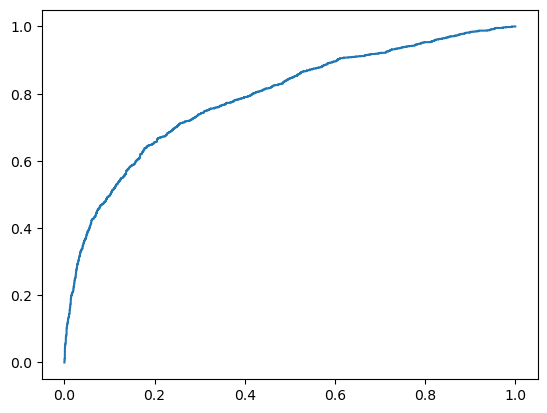

In [495]:
# create AUC score
y_pred_proba_sfm = lr5.predict_proba(x_test_sf)[:,1]

fpr, tpr, threshold = roc_curve(y_test_f, y_pred_proba_sfm)

print(f"The roc_score is : {roc_auc_score(y_test_f, y_pred_proba_sfm)}")
#plot
plt.plot(fpr, tpr);

**Key Insight:**

The model now correctly identifies more positive cases (higher TP) but makes many more false positive errors (higher FP). It's "guessing" class 1 more often, which helps recall but hurts precision.

* **Performance on Class 0 (Negative Class):**
    * **Recall** has dropped from 0.95 to **0.81**. The model is now worse at correctly identifying all the true negative cases.

* **Performance on Class 1 (Positive Class):**
    * **Recall** has improved significantly from 0.43 to **0.64**. The model now finds 64% of all people who actually got the vaccine, which is much better.
    * **Precision**, however, is now very low at **0.48**. This means that when the model predicts someone got the vaccine, it's wrong more than half the time (52% of the time).
    * The **F1-score** has only slightly increased from 0.53 to **0.55**, indicating that the major gain in recall was almost entirely cancelled out by the loss in precision.

The **AUC score of 0.79** indicates a **fair** level of separability between the positive and negative classes.

* **Comparison:** This score is a step down from the previous model's **0.82**. This confirms that the new model is fundamentally less capable of distinguishing between the two classes. The trade-off made to improve recall has weakened the model's overall predictive power.

This model represents a trade-off. By adjusting its parameters or features, it has successfully **increased the recall for the minority class (1)**, meaning it misses fewer positive cases. However, this came at the cost of overall accuracy and precision of class(1)


### SEASONAL VACCINE

In [227]:
# seperate features from predictor
x1 = df.drop(["respondent_id","seasonal_vaccine","h1n1_vaccine"], axis=1)
y_seasonal = df.seasonal_vaccine

In [498]:
#seperate train and test set
x_train, x_test, y_train_seasonal, y_test_seasonal = train_test_split(x1, y_seasonal, test_size=.2, random_state=42, stratify=y_seasonal)

#check shape
x_train.shape, x_test.shape, y_train_seasonal.shape, y_test_seasonal.shape

((21365, 36), (5342, 36), (21365,), (5342,))

In [504]:
#Base model(logistic regresion)
lr1_seasonal = LogisticRegression()
lr1_seasonal.fit(x_train, y_train_seasonal)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [506]:
print(f"The model score on training dataset is {lr1_seasonal.score(x_train, y_train_seasonal)*100:.2f}%")

The model score on training dataset is 77.55%


In [508]:
#check prediction and accuracy

y_pred_seasonal = lr1_seasonal.predict(x_test)

#accuracy
accuracy_score(y_test_seasonal, y_pred_seasonal)*100

77.96705353800075

In [510]:
conf = confusion_matrix(y_test_seasonal, y_pred_seasonal)
conf

array([[2348,  507],
       [ 670, 1817]], dtype=int64)

In [512]:
#classification report
print(classification_report(y_test_seasonal, y_pred_seasonal))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2855
           1       0.78      0.73      0.76      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



The roc_score is : 0.8514915740484496


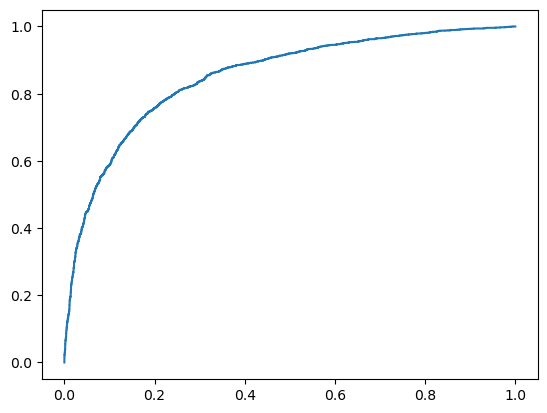

In [514]:
# create AUC score
y_pred_proba_seasonal = lr1_seasonal.predict_proba(x_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test_seasonal, y_pred_proba_seasonal)

print(f"The roc_score is : {roc_auc_score(y_test_seasonal, y_pred_proba_seasonal)}")
#plot
plt.plot(fpr, tpr);

#### Feature Selection

In [242]:
# first do feature scaling

ss = StandardScaler()
x_train_seasonal_sc =ss.fit_transform(x_train)
x_test__seasonal_sc =ss.transform(x_test)

In [244]:
lr2_seasonal = LogisticRegression()
lr2_seasonal.fit(x_train_seasonal_sc, y_train_seasonal)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [250]:
# select best features
# Use Stratified K-Folds for robust cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfe1 = RFECV(estimator=lr2_seasonal, min_features_to_select=10, step=1, cv=cv, scoring="neg_mean_squared_error")
rfe1 = rfe1.fit(x1,y_seasonal)
rfe1

,estimator,LogisticRegression()
,step,1
,min_features_to_select,10
,cv,StratifiedKFo... shuffle=True)
,scoring,'neg_mean_squared_error'
,verbose,0
,n_jobs,None
,importance_getter,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001


In [252]:
# we make our work easier by seeing which features have been selected
rfe1.get_feature_names_out()

array(['h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1',
       'doctor_recc_seasonal', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'health_insurance',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education',
       'income_poverty', 'census_msa', 'race_Hispanic',
       'race_Other or Multiple', 'race_White', 'rent_or_own_Rent',
       'employment_status_Not in Labor Force',
       'employment_status_Unemployed'], dtype=object)

In [256]:
# select features
x3 = df[['h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1',
       'doctor_recc_seasonal', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'health_insurance',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education',
       'income_poverty', 'census_msa', 'race_Hispanic',
       'race_Other or Multiple', 'race_White', 'rent_or_own_Rent',
       'employment_status_Not in Labor Force',
       'employment_status_Unemployed']]


In [585]:
#seperate train and test set
x_train, x_test, y_train_seasonal, y_test_seasonal = train_test_split(x3, y_seasonal, test_size=.2, random_state=42, stratify=y_seasonal)

#check shape
x_train.shape, x_test.shape, y_train_seasonal.shape, y_test_seasonal.shape

((21365, 24), (5342, 24), (21365,), (5342,))

In [518]:
#Base model(logistic regresion)

lr3_seasonal = LogisticRegression(max_iter=1000, class_weight="balanced",random_state=42)
lr3_seasonal.fit(x_train, y_train_seasonal)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [520]:
print(f"The model score on training dataset is {lr3_seasonal.score(x_train, y_train_seasonal)*100:.2f}%")

The model score on training dataset is 77.45%


In [522]:
#check prediction and accuracy

y_pred_seasonal = lr3_seasonal.predict(x_test)

#accuracy
accuracy_score(y_test_seasonal, y_pred_seasonal)*100

78.0980906027705

In [524]:
#classification report
print(classification_report(y_test_seasonal, y_pred_seasonal))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2855
           1       0.77      0.76      0.76      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



The roc_score is : 0.8513179214929896


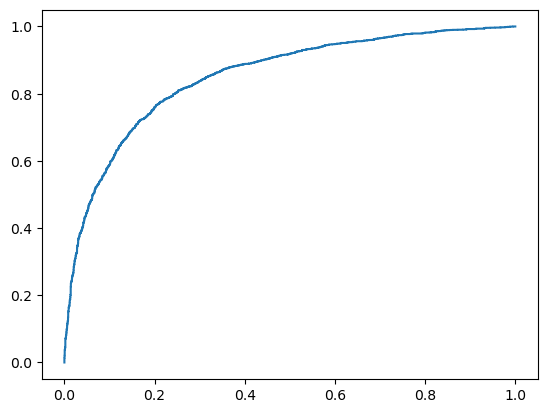

In [526]:
# create AUC score
y_pred_proba_seasonal3 = lr3_seasonal.predict_proba(x_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test_seasonal, y_pred_proba_seasonal3)

print(f"The roc_score is : {roc_auc_score(y_test_seasonal, y_pred_proba_seasonal3)}")
#plot
plt.plot(fpr, tpr);

#### 1. Accuracy and Overfitting

* **Training Accuracy:** 77.45%
* **Testing Accuracy:** 78.09%

The testing accuracy is slightly higher than the training accuracy, and both scores are very close. This is an excellent sign, indicating that the **model is not overfitting** to the training data and generalizes well to new, unseen data. An overall accuracy of **78%** is a respectable starting point.

---

#### 2. Classification Report Analysis

The classification report provides a more detailed look at the model's performance for each class:

* **Class 0 (Negative Class):** The model achieved a **precision of 0.79** and a **recall of 0.80**. This means it's quite reliable when predicting class 0 and successfully identifies 80% of all true instances of this class.
* **Class 1 (Positive Class):** Performance for class 1 is also solid, with a **precision of 0.77** and a **recall of 0.76**.
* **F1-Scores:** The F1-scores (0.80 for class 0 and 0.76 for class 1) show a healthy balance between precision and recall for both classes.

The performance is well-balanced across both classes, which was likely aided by setting the `class_weight="balanced"` parameter during model training.

---

#### 3. ROC Curve and AUC Score

* **AUC Score:** 0.85

The Area Under the Curve (AUC) score is **0.85**, which is generally considered **good to excellent**. This score reflects the model's ability to distinguish between the positive and negative classes. An AUC of 0.85 means there is an 85% chance that the model will correctly rank a randomly chosen positive sample higher than a randomly chosen negative sample. The shape of the ROC curve, bending strongly towards the top-left corner, visually confirms this strong discriminative power.

---

### Conclusion ✅

Overall, the logistic regression model is a **solid performer**. It demonstrates good predictive accuracy, maintains a strong balance between precision and recall for both classes, and shows a great ability to separate the classes as measured by the AUC score. It serves as an effective and reliable baseline for this problem.

## DescisionTree

### H1N1 Vaccine

In [298]:
tree_model = DecisionTreeClassifier()
tree_model.fit(x_train_sf, y_train_f)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [300]:
tree_model.score(x_train_sf, y_train_f)

0.9952258366487245

In [302]:
y_pred_tree = tree_model.predict(x_test_sf)
result ={"Actual":y_test_f, "Predicted": y_pred_tree}
pd.DataFrame(result)[:5]

,Actual,Predicted
23200,1,0
1928,1,1
24951,0,0
20228,0,1
20206,0,0


In [304]:
# model score
accuracy_score(y_test_f, y_pred_tree)

0.7502807937102209

##### Pruning the Tree

In [306]:
# pruning the tree 
tree_model1 = DecisionTreeClassifier(max_depth=3,class_weight="balanced")
tree_model1.fit(x_train_sf, y_train_f)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [308]:
y_pred_tree1 = tree_model1.predict(x_test_sf)

In [310]:
tree_model1.score(x_train_sf, y_train_f)

0.7899368125438802

In [312]:
accuracy_score(y_test_f, y_pred_tree1)

0.7888431299138899

##### Creating a cart model

In [529]:
tree_model2 = DecisionTreeClassifier(criterion="entropy", max_depth=3,class_weight="balanced")
tree_model2.fit(x_train_sf, y_train_f)

,criterion,'entropy'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [531]:
tree_model2.score(x_train_sf, y_train_f)

0.7899368125438802

In [533]:
#2. predict
y_pred_tree2 = tree_model2.predict(x_test_sf)

#3. model score
accuracy_score(y_test_f, y_pred_tree2)

0.7888431299138899

In [535]:
#check confusion matrix
conf_matrix = confusion_matrix(y_test_f, y_pred_tree2)
conf_matrix

array([[3487,  720],
       [ 408,  727]], dtype=int64)

In [537]:
#classification report
print(classification_report(y_test_f, y_pred_tree2))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4207
           1       0.50      0.64      0.56      1135

    accuracy                           0.79      5342
   macro avg       0.70      0.73      0.71      5342
weighted avg       0.81      0.79      0.80      5342



The roc_score is : 0.7918414767081086


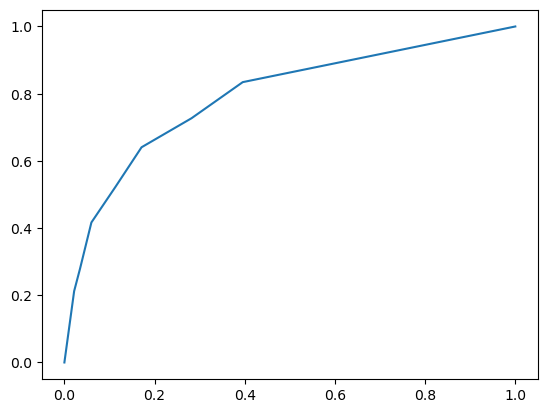

In [539]:
# create AUC score
y_pred_proba_tree = tree_model2.predict_proba(x_test_sf)[:,1]

fpr, tpr, threshold = roc_curve(y_test_f, y_pred_proba_tree)

print(f"The roc_score is : {roc_auc_score(y_test_f, y_pred_proba_tree)}")
#plot
plt.plot(fpr, tpr);

### Seasonal vaccine

In [541]:
tree_model_seasonal = DecisionTreeClassifier(max_depth=3,class_weight="balanced",criterion="gini")
tree_model_seasonal.fit(x_train, y_train_seasonal)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [543]:
tree_model_seasonal.score(x_train, y_train_seasonal)

0.7282939386847648

In [545]:
y_pred_tree_seasonal = tree_model_seasonal.predict(x_test)
result ={"Actual":y_test_seasonal, "Predicted": y_pred_tree_seasonal}
pd.DataFrame(result)[:5]

,Actual,Predicted
7314,0,0
18541,1,1
11811,0,0
22377,1,0
13716,0,0


In [547]:
# model score
accuracy_score(y_test_seasonal, y_pred_tree_seasonal)

0.7315612130288282

In [549]:
#classification report
print(classification_report(y_test_seasonal, y_pred_tree_seasonal))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      2855
           1       0.74      0.66      0.70      2487

    accuracy                           0.73      5342
   macro avg       0.73      0.73      0.73      5342
weighted avg       0.73      0.73      0.73      5342



## RandomForestClassifier

### H1N1 Vaccine

In [371]:
# lets balance the classes
#instantiate smoten
ss = SMOTEN(random_state=42)

x_train_sm, y_train_sm = ss.fit_resample(x_train_sf, y_train_f)

#check on whether SMOTEN worked
print(f" Original values \n {y_train_f.value_counts()}")
print("*****" *10)
print(f"Smoted values \n {y_train_sm.value_counts()}")

 Original values 
 h1n1_vaccine
0    16826
1     4539
Name: count, dtype: int64
**************************************************
Smoted values 
 h1n1_vaccine
0    16826
1    16826
Name: count, dtype: int64


In [375]:
#instantiate the model
rf = RandomForestClassifier()

#train the model
rf.fit(x_train_sf, y_train_f)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [381]:
#check training score
rf.score(x_train_sf, y_train_f)

0.9952258366487245

In [383]:
#check prediction
y_pred_rf = rf.predict(x_test_sf)

#check model accuracy
acc = print(f"The model accuracy is {accuracy_score(y_test_f, y_pred_rf)*100:.2f}%")
acc

The model accuracy is 83.11%


In [385]:
conf = confusion_matrix(y_test_f, y_pred_rf)
conf

array([[3966,  241],
       [ 661,  474]], dtype=int64)

In [387]:
#classification report
print(classification_report(y_test_f, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4207
           1       0.66      0.42      0.51      1135

    accuracy                           0.83      5342
   macro avg       0.76      0.68      0.71      5342
weighted avg       0.82      0.83      0.82      5342



#### With class balance

In [466]:
#instantiate smoten
smot = SMOTEN(random_state=42)

x_train_sm, y_train_sm = ss.fit_resample(x_train_sf, y_train_f)

#check on whether SMOTEN worked
print(f" Original values \n {y_train_f.value_counts()}")
print("*****" *10)
print(f"Smoted values \n {y_train_sm.value_counts()}")

 Original values 
 h1n1_vaccine
0    16826
1     4539
Name: count, dtype: int64
**************************************************
Smoted values 
 h1n1_vaccine
0    16826
1    16826
Name: count, dtype: int64


In [389]:
#instantiate the model
rf1 = RandomForestClassifier()

#train the model
rf1.fit(x_train_sm, y_train_sm)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [391]:
#check training score
rf1.score(x_train_sm, y_train_sm)

0.9942648282420065

In [393]:
#check prediction
y_pred_rfm = rf1.predict(x_test_sf)

#check model accuracy
acc = print(f"The model accuracy is {accuracy_score(y_test_f, y_pred_rfm)*100:.2f}%")
acc

The model accuracy is 81.07%


In [395]:
conf = confusion_matrix(y_test_f, y_pred_rfm)
conf

array([[3768,  439],
       [ 572,  563]], dtype=int64)

In [397]:
#classification report
print(classification_report(y_test_f, y_pred_rfm))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4207
           1       0.56      0.50      0.53      1135

    accuracy                           0.81      5342
   macro avg       0.72      0.70      0.70      5342
weighted avg       0.80      0.81      0.81      5342



#### Hyperparameter testing with balanced class

In [400]:
# GridSearchCV
#params
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [3, 5, 7, 8, None],
              "min_samples_split":[2, 5, 8, 10]
             }

# Use Stratified K-Folds for robust cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#Instantiate gridsearch

grid_search1 = GridSearchCV(estimator=rf1, param_grid=param_grid, cv=cv, scoring='roc_auc')
grid_search1.fit(x_train_sm, y_train_sm)

,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [404]:
#get the best params
grid_search1.best_params_

{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}

In [406]:
#Recreate the model with the best params
rf1sm = RandomForestClassifier(criterion="entropy", max_depth=None, min_samples_split=2)

#train the model
rf1sm.fit(x_train_sm, y_train_sm)

#check score
rf1sm.score(x_train_sm, y_train_sm)

0.9942945441578509

In [408]:
#predict
y_pred_rf1sm = rf1sm.predict(x_test_sf)

#check accuracy
accu = print(f"The model accuracy is {accuracy_score(y_test_f, y_pred_rf1sm)*100:.2f}%")
accu

The model accuracy is 80.79%


In [410]:
#check confusion matrix
conf_matrix = confusion_matrix(y_test_f, y_pred_rf1sm)
conf_matrix

array([[3757,  450],
       [ 576,  559]], dtype=int64)

In [412]:
#classification report
print(classification_report(y_test_f, y_pred_rf1sm))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4207
           1       0.55      0.49      0.52      1135

    accuracy                           0.81      5342
   macro avg       0.71      0.69      0.70      5342
weighted avg       0.80      0.81      0.80      5342



#### Hyperparameter testing without class balance

In [415]:
# GridSearchCV
#params
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [3, 5, 7, 8, None],
              "min_samples_split":[2, 5, 8, 10]
             }


#Instantiate gridsearch

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring="accuracy")
grid_search.fit(x_train_sf, y_train_f)

,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [417]:
#get the best params
grid_search.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10}

In [419]:
#Recreate the model with the best params
rf2 = RandomForestClassifier(criterion="gini", max_depth=None, min_samples_split=10)

#train the model
rf2.fit(x_train_sf, y_train_f)

#check score
rf2.score(x_train_sf, y_train_f)

0.8980575707933536

In [421]:
#predict
y_pred_CV = rf2.predict(x_test_sf)

#check accuracy
acc1 = print(f"The model accuracy is {accuracy_score(y_test_f, y_pred_CV)*100:.2f}%")
acc1

The model accuracy is 83.73%


In [423]:
#check confusion matrix
conf_matrix = confusion_matrix(y_test_f, y_pred_CV)
conf_matrix

array([[3994,  213],
       [ 656,  479]], dtype=int64)

In [425]:
#classification report
print(classification_report(y_test_f, y_pred_CV))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4207
           1       0.69      0.42      0.52      1135

    accuracy                           0.84      5342
   macro avg       0.78      0.69      0.71      5342
weighted avg       0.82      0.84      0.82      5342



#### RandomSearch

In [427]:
from scipy.stats import randint

#creats param dist
param_dist = {"criterion": ["gini", "entropy"],
              "max_depth": randint(1, 10),
              "min_samples_split":randint(2,20)
             }
#instantiate the random search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,\
                                  n_iter=10, cv=5, scoring="accuracy", random_state=42)

random_search.fit(x_train_sf, y_train_f)

,estimator,RandomForestClassifier()
,param_distributions,"{'criterion': ['gini', 'entropy'], 'max_depth': <scipy.stats....002501502E190>, 'min_samples_split': <scipy.stats....002501502C190>}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [429]:
#check best params
random_search.best_params_

{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 8}

In [551]:
#recreate the model# assume we got the below result
rf3 = RandomForestClassifier(criterion="entropy", max_depth=8, min_samples_split=4)

#train the model
rf3.fit(x_train_sf, y_train_f)

#check score
rf3.score(x_train_sf, y_train_f)

0.8441844137608238

In [553]:
#predict
y_pred_rdm = rf3.predict(x_test_sf)

#check accuracy
acc2 = print(f"The model accuracy is {accuracy_score(y_test_f, y_pred_rdm)*100:.2f}%")
acc2

The model accuracy is 83.40%


In [555]:
#check confusion matrix
conf_matrix = confusion_matrix(y_test_f, y_pred_rdm)
conf_matrix

array([[4044,  163],
       [ 724,  411]], dtype=int64)

In [557]:
#classification report
print(classification_report(y_test_f, y_pred_rdm))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4207
           1       0.72      0.36      0.48      1135

    accuracy                           0.83      5342
   macro avg       0.78      0.66      0.69      5342
weighted avg       0.82      0.83      0.81      5342



The roc_score is : 0.8230579619241687


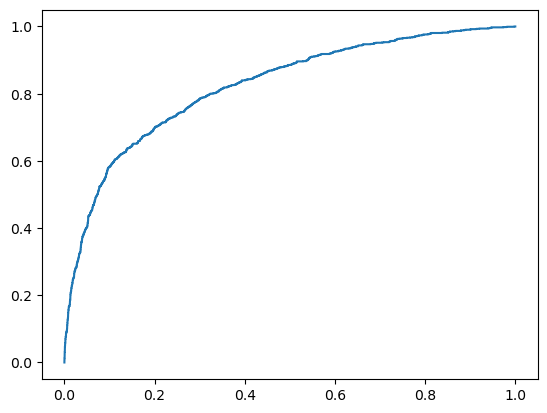

In [559]:
# create AUC score
y_pred_proba_rdm = rf3.predict_proba(x_test_sf)[:,1]

fpr, tpr, threshold = roc_curve(y_test_f, y_pred_proba_rdm)

print(f"The roc_score is : {roc_auc_score(y_test_f, y_pred_proba_rdm)}")
#plot
plt.plot(fpr, tpr);

### Model Performance Evaluation: Random Forest

This Random Forest model shows a notable improvement in overall accuracy compared to the baseline, but a deeper look into the classification report reveals a significant imbalance in its predictive power.

---

#### 1. Accuracy and Confusion Matrix

* **Overall Accuracy:** 83.40%

The model achieves a **high accuracy of 83.40%**. However, accuracy can be a misleading metric, especially with imbalanced datasets. The confusion matrix `[[4044, 163], [724, 411]]` reveals the source of this high accuracy: the model is excellent at predicting the majority class (class 0) but struggles significantly with the minority class (class 1).

---

#### 2. Classification Report Analysis

The classification report highlights a clear performance imbalance:

* **Class 0 (Majority Class):** The model performs exceptionally well here, with a **precision of 0.85** and a very high **recall of 0.96**. It correctly identifies 96% of all true class 0 instances.
* **Class 1 (Minority Class):** The model's performance for this class is poor.
    * **Recall is only 0.36**, meaning the model fails to identify nearly two-thirds (64%) of the actual positive cases (724 False Negatives). This is a major weakness. 😟
    * **Precision is 0.72**, which is decent, but the extremely low recall results in a low **F1-score of 0.48**.

This indicates the model is biased towards predicting the majority class. While it's accurate when it *does* predict class 1, it misses most of them.

---

#### 3. ROC Curve and AUC Score

* **AUC Score:** 0.82

The **AUC score of 0.82 is good**. It suggests that the model has a strong capability to distinguish between the two classes across different thresholds. The ROC curve's shape confirms this. However, the default 0.5 threshold used for the classification report results in the poor recall for class 1. You could potentially find a better-balanced trade-off between precision and recall by choosing a different classification threshold.

---

### Conclusion & Recommendations 💡

**Conclusion:** The model has high overall accuracy and good discriminative ability (AUC=0.82), but it is **not a well-balanced classifier**. It achieves its high accuracy by sacrificing the detecti  it slightly lowers the overall accuracy.

### Seasonal Vaccine

In [565]:
#instantiate the model
rf_seasonal = RandomForestClassifier()

#train the model
rf_seasonal.fit(x_train, y_train_seasonal)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [445]:
#check training score
rf_seasonal.score(x_train, y_train_seasonal)

0.9783758483501053

In [447]:
#check prediction
y_pred_rf_seasonal = rf_seasonal.predict(x_test)

#check model accuracy
print(f"The model accuracy is {accuracy_score(y_test_seasonal, y_pred_rf_seasonal)*100:.2f}%")

The model accuracy is 76.28%


In [449]:
print(confusion_matrix(y_test_seasonal, y_pred_rf_seasonal))

[[2266  589]
 [ 678 1809]]


In [451]:
#classification report
print(classification_report(y_test_seasonal, y_pred_rf_seasonal))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2855
           1       0.75      0.73      0.74      2487

    accuracy                           0.76      5342
   macro avg       0.76      0.76      0.76      5342
weighted avg       0.76      0.76      0.76      5342



#### Using RandomizedSearchCV

In [462]:
# Create a Machine Learning Pipeline
# This pipeline ensures SMOTE is only applied to the training data during cross-validation.
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# A dictionary defining the hyperparameters and the range of values to test.
param_dist = {
    'rf__n_estimators': randint(100, 1000),
    'rf__max_depth': randint(10, 50),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 20),
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__class_weight': ['balanced', None]
}

# RandomizedSearchCV efficiently searches for the best hyperparameters from the defined space.
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

# Fit the random search model to the training data.
random_search.fit(x_train, y_train_seasonal)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'rf__class_weight': ['balanced', None], 'rf__max_depth': <scipy.stats....002501DC087D0>, 'rf__max_features': ['sqrt', 'log2', ...], 'rf__min_samples_leaf': <scipy.stats....002501DC08550>, ...}"
,n_iter,100
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [587]:
best_model = random_search.best_estimator_

In [589]:
best_model.score(x_train, y_train_seasonal)

0.8086590217645682

In [571]:
# Use the best model to make predictions on the unseen test data.
y_pred_seasonal_rdm = best_model.predict(x_test)

print(accuracy_score(y_test_seasonal, y_pred_seasonal_rdm))

0.7804193186072632


In [573]:
print(classification_report(y_test_seasonal, y_pred_seasonal_rdm))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2855
           1       0.77      0.76      0.76      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



The roc_score is : 0.8544209926644822


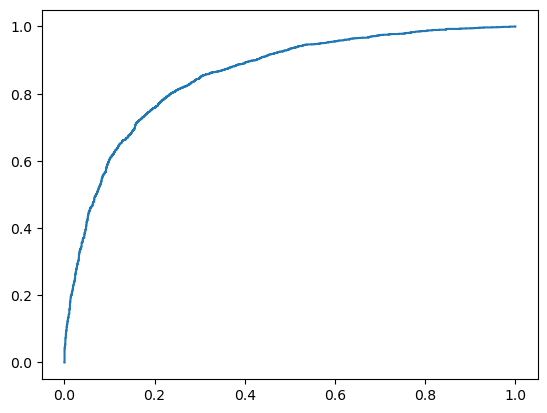

In [575]:
# create AUC score
y_pred_proba_seasonalrf = best_model.predict_proba(x_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test_seasonal, y_pred_proba_seasonalrf)

print(f"The roc_score is : {roc_auc_score(y_test_seasonal, y_pred_proba_seasonalrf)}")
#plot
plt.plot(fpr, tpr);